In [1]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from imutils.video import FPS
from sklearn import metrics
from imutils import paths
import dlib.cuda as cuda
import face_recognition
import numpy as np
import argparse
import imutils
import pickle
import time
import cv2
import os

## Main Streaming 

In [5]:
def main():

    print("[INFO] starting clustering agent...")
    clt = DBSCAN(min_samples=8, metric='euclidean', eps= 0.4435, n_jobs=-1)
    
    print("[INFO] starting video stream...")
    vs = VideoStream(src=0).start()
    time.sleep(2.0)

    # start the FPS throughput estimator
    fps = FPS().start()
    encodings = []
    labelSet = set()

    # loop over frames from the video file stream
    while True:
        # grab the frame from the threaded video stream
        frame = vs.read()
        frame = imutils.resize(frame, width=500)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes = face_recognition.face_locations(rgb,model="cnn")

        # compute the facial embedding for the face
        encodingsSize = len(encodings)
        new_encodings = face_recognition.face_encodings(rgb, boxes)
        if new_encodings:
            encodings += new_encodings
            for predicted_id in clt.fit_predict(encodings):
                if predicted_id != -1: 
                    labelSet.add(i)
        for i, box in enumerate(boxes):
                # coordinates
                (top, right, bottom, left) = box
                y = top - 10 if top - 10 > 10 else top + 10

                # perform classification to recognize the face
                name = "ID"
                text = "{}: {}".format(name, clt.labels_[encodingsSize+i])

                # plot at image
                cv2.rectangle(frame, (right,top), (left, bottom), (0, 0, 255), 2)
                cv2.putText(frame, text, (left, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 200), 2)

        cv2.putText(frame, 'Counting: {}'.format(len(labelSet)), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 100, 200), 2)

        
        # update the FPS counter
        fps.update()

        # show the output frame
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # stop the timer and display FPS information
    fps.stop()
    print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

    # do a bit of cleanup
    cv2.destroyAllWindows()
    vs.stop()
    
    return encodings, clt

In [8]:
encodings, clt = main()

[INFO] starting clustering agent...
[INFO] starting video stream...
[INFO] elasped time: 24.55
[INFO] approx. FPS: 11.69


## Ploting

In [9]:
X = encodings
X = StandardScaler().fit_transform(X)

In [10]:
db = clt
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

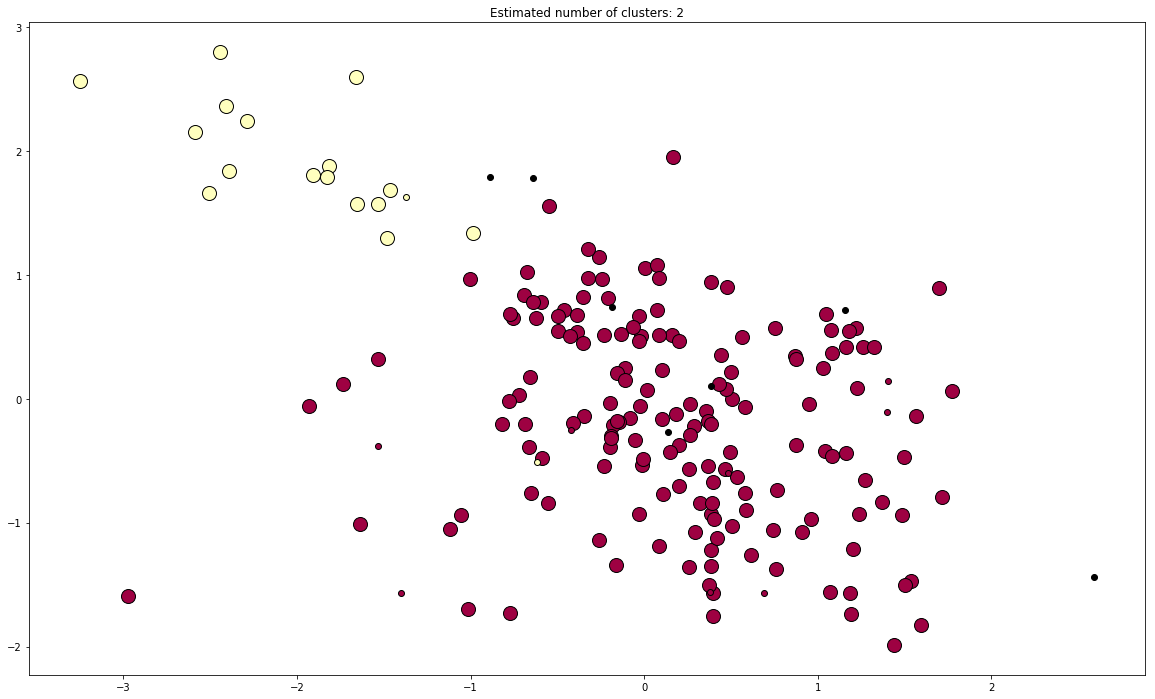

In [11]:
# Black removed and is used for noise instead.
plt.figure(figsize=(20,12))

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()